In [1]:
import numpy as np
import cv2
import os
from PIL import Image

def read_image_and_name(path):
    imgdir = os.listdir(path)
    imglst = []
    imgs = []
    for v in imgdir:
        imglst.append(path + v)
        imgs.append(cv2.imread(path + v))
    print(imglst)
    print('original images shape: ' + str(np.array(imgs).shape))
    return imglst,imgs

def read_label_and_name(path):
    labeldir = os.listdir(path)
    labellst = []
    labels = []
    for v in labeldir:
        labellst.append(path + v)
        labels.append(np.asarray(Image.open(path + v)))
    print(labellst)
    print('original labels shape: ' + str(np.array(labels).shape))
    return labellst,labels

def resize(imgs,resize_height, resize_width):
    img_resize = []
    for file in imgs:
        img_resize.append(cv2.resize(file,(resize_height,resize_width)))
    return img_resize

#将N张576x576的图片裁剪成48x48
def crop(image,dx):
    list = []
    for i in range(image.shape[0]):
        for x in range(image.shape[1] // dx):
            for y in range(image.shape[2] // dx):
                list.append(image[ i,  y*dx : (y+1)*dx,  x*dx : (x+1)*dx]) #这里的list一共append了20x12x12=2880次所以返回的shape是(2880,48,48)
    return np.array(list)

# 网络预测输出转换成图像子块
# 网络预测输出 size=[Npatches, patch_height*patch_width, 2]
def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    assert (len(pred.shape)==3)  #3D array: (Npatches,height*width,2)
    assert (pred.shape[2]==2 )  #check the classes are 2  # 确认是否为二分类
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  #(Npatches,height*width)
    if mode=="original": # 网络概率输出
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1] #pred[:, :, 0] 是反分割图像输出 pred[:, :, 1]是分割输出
    elif mode=="threshold": # 网络概率-阈值输出
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                if pred[i,pix,1]>=0.5:
                    pred_images[i,pix]=1
                else:
                    pred_images[i,pix]=0
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    # 输出形式改写成(Npatches,1, patch_height, patch_width)
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images


In [2]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout #core内部定义了一系列常用的网络层，包括全连接、激活层等
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    #data_format：字符串，“channels_first”或“channels_last”之一，代表图像的通道维的位置。
    #以128x128的RGB图像为例，“channels_first”应将数据组织为（3,128,128），而“channels_last”应将数据组织为（128,128,3）。该参数的默认值是~/.keras/keras.json中设置的值，若从未设置过，则为“channels_last”。
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    #1×1的卷积的作用
	#大概有两个方面的作用：1. 实现跨通道的交互和信息整合2. 进行卷积核通道数的降维和升维。
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,patch_height*patch_width))(conv6) #此时output的shape是(batchsize,2,patch_height*patch_width)
    conv6 = core.Permute((2,1))(conv6)    #此时output的shape是(Npatch,patch_height*patch_width,2)即输出维度是(Npatch,2304,2)
    ############
    conv7 = core.Activation('softmax')(conv6)
    model = Model(inputs=inputs, outputs=conv7)
    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
    return model

    '''
    模型Model的compile方法:
	compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics = None, target_tensors=None)
	本函数编译模型以供训练，参数有
	optimizer：         优化器，为预定义优化器名或优化器对.可以在调用model.compile()之前初始化一个优化器对象，然后传入该函数。
	loss：              损失函数，为预定义损失函数名或一个目标函数
	metrics：           列表，包含评估模型在训练和测试时的性能的指标，典型用法是metrics=['accuracy']如果要在多输出模型中为不同的输出指定不同的指标，可像该参数传递一个字典，例如metrics={'ouput_a': 'accuracy'}
	sample_weight_mode：如果需要按时间步为样本赋权（2D权矩阵），将该值设为“temporal”。默认为“None”，代表按样本赋权（1D权）。如果模型有多个输出，可以向该参数传入指定sample_weight_mode的字典或列表。在下面fit函数的解释中有相关的参考内容。
	weighted_metrics:   metrics列表，在训练和测试过程中，这些metrics将由sample_weight或clss_weight计算并赋权
	target_tensors:     默认情况下，Keras将为模型的目标创建一个占位符，该占位符在训练过程中将被目标数据代替。如果你想使用自己的目标张量（相应的，Keras将不会在训练时期望为这些目标张量载入外部的numpy数据），你可以通过该参数手动指定。目标张量可以是一个单独的张量（对应于单输出模型），也可以是一个张量列表，或者一个name->tensor的张量字典。
	kwargs：            使用TensorFlow作为后端请忽略该参数，若使用Theano/CNTK作为后端，kwargs的值将会传递给 K.function。如果使用TensorFlow为后端，这里的值会被传给tf.Session.run
	在Keras中，compile主要完成损失函数和优化器的一些配置，是为训练服务的。
    '''



In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)




#参数和路径
resize_height, resize_width = (576, 576)
dx = 48
img_path = 'DRIVE/training/images/'
label_path = 'DRIVE/training/1st_manual/'

#读取数据并resize
imglst,images = read_image_and_name(img_path)
labellst,labels = read_label_and_name(label_path)
imgs_resize = resize(images,resize_height, resize_width)
labels_resize = resize(labels,resize_height, resize_width)

#将imgs列表和manuals列表转换成numpy数组
X_train = np.array(imgs_resize)
Y_train = np.array(labels_resize)
print(X_train.shape)
print(Y_train.shape)

#标准化
X_train = X_train.astype('float32')/255
Y_train = Y_train.astype('float32')/255







# #提取训练集的G通道
# X_train = X_train[...,1]

# #对训练数据进行裁剪
# X_train = crop(X_train,dx)
# Y_train = crop(Y_train,dx)
# print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
# print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)

# #X_train增加一维变成(2880,1,48,48)
# X_train = X_train[:,np.newaxis, ...]
# print('X_train shape: '+str(X_train.shape))




#将单通道转换为三通道
X_train_0=X_train[...,0]
X_train_1=X_train[...,1]
X_train_2=X_train[...,2]
X_train_0 = crop(X_train_0,dx)
X_train_1 = crop(X_train_1,dx)
X_train_2 = crop(X_train_2,dx)
Y_train = crop(Y_train,dx)
X_train_0 = X_train_0[:,np.newaxis, ...]
X_train_1 = X_train_1[:,np.newaxis, ...]
X_train_2 = X_train_2[:,np.newaxis, ...]
print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)
X_train=np.concatenate((X_train_0,X_train_1,X_train_2),axis=1)



#Y_train改变shape变成(2880,2304),保持第一维不变，其他维合并
Y_train = Y_train.reshape(Y_train.shape[0],-1)
print('Y_train shape: '+str(Y_train.shape))
Y_train =Y_train[..., np.newaxis]  #增加一维变成(2880,2304,1)
print('Y_train shape: '+str(Y_train.shape))
temp = 1 - Y_train
Y_train = np.concatenate([Y_train, temp], axis=2) #变成(2880,2304,2)
print('Y_train shape: '+str(Y_train.shape))

#获得model
model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3])
model.summary() #输出参数Param计算过程
checkpointer = ModelCheckpoint(filepath='best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer])
print('ok')


['DRIVE/training/images/21_training.tif', 'DRIVE/training/images/22_training.tif', 'DRIVE/training/images/23_training.tif', 'DRIVE/training/images/24_training.tif', 'DRIVE/training/images/25_training.tif', 'DRIVE/training/images/26_training.tif', 'DRIVE/training/images/27_training.tif', 'DRIVE/training/images/28_training.tif', 'DRIVE/training/images/29_training.tif', 'DRIVE/training/images/30_training.tif', 'DRIVE/training/images/31_training.tif', 'DRIVE/training/images/32_training.tif', 'DRIVE/training/images/33_training.tif', 'DRIVE/training/images/34_training.tif', 'DRIVE/training/images/35_training.tif', 'DRIVE/training/images/36_training.tif', 'DRIVE/training/images/37_training.tif', 'DRIVE/training/images/38_training.tif', 'DRIVE/training/images/39_training.tif', 'DRIVE/training/images/40_training.tif']
original images shape: (20, 584, 565, 3)
['DRIVE/training/1st_manual/21_manual1.gif', 'DRIVE/training/1st_manual/22_manual1.gif', 'DRIVE/training/1st_manual/23_manual1.gif', 'DRIV

36/36 - 3s - loss: 0.3500 - accuracy: 0.9007 - val_loss: 0.2605 - val_accuracy: 0.9162
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.91623
36/36 - 2s - loss: 0.2626 - accuracy: 0.9133 - val_loss: 0.2601 - val_accuracy: 0.9162
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.91623
36/36 - 2s - loss: 0.2600 - accuracy: 0.9133 - val_loss: 0.2543 - val_accuracy: 0.9162
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.91623
36/36 - 2s - loss: 0.2549 - accuracy: 0.9133 - val_loss: 0.2424 - val_accuracy: 0.9162
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.91623 to 0.91784, saving model to best_weights.h5
36/36 - 3s - loss: 0.2318 - accuracy: 0.9136 - val_loss: 0.2057 - val_accuracy: 0.9178
Epoch 6/20

Epoch 00006: val_accuracy improved from 0.91784 to 0.93687, saving model to best_weights.h5
36/36 - 3s - loss: 0.2059 - accuracy: 0.9254 - val_loss: 0.1829 - val_accuracy: 0.9369
Epoch 7/20

Epoch 00007: val_accuracy improved from 0.93687 to 0.9424

X_test original shape: (576, 576)
input shape: (144, 1, 48, 48)
predict shape: (144, 2304, 2)


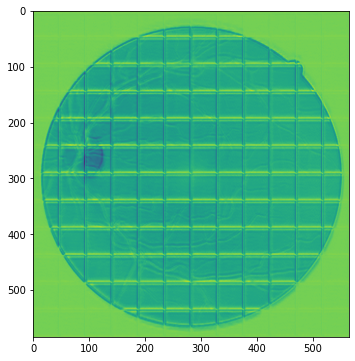

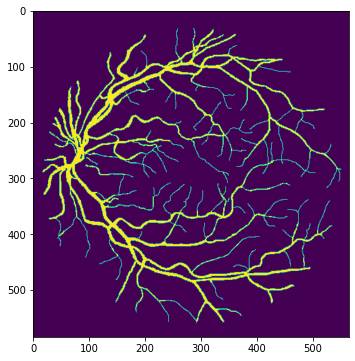

In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt



resize_height, resize_width = (576, 576)
dx = 48
#读取预测图片
imgs = cv2.imread('DRIVE/test/images/01_test.tif')[...,1] #读取G通道
imgs = np.array(cv2.resize(imgs,(resize_height,resize_width))) #imgs现在是576x576大小
#读取预测图片的标签
label = np.array(Image.open('DRIVE/test/1st_manual/01_manual1.gif'))
#预测图片和标签标准化
X_test = imgs.astype('float32')/255
print('X_test original shape: '+str(X_test.shape))
Y_test = label.astype('float32')/255


#对预测图片进行裁剪按行优先，裁剪成(144,48,48)
list = []
for i in range(resize_height//dx):
    for j in range(resize_width//dx):
        list.append(X_test[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
X_test = np.array(list)[:,np.newaxis,...] #增加一维变成(144,1,48,48)
print('input shape: '+str(X_test.shape))

#加载模型和权重并预测
model = get_unet(1,dx,dx)

# model.load_weights('best_weights.h5')

Y_pred = model.predict(X_test)
print('predict shape: '+str(Y_pred.shape)) #预测结果的shape是(Npatches,patch_height*patch_width,2)

#把预测输出的numpy数组拼接还原再显示
Y_pred = Y_pred[..., 0]  #二分类提取出分割前景 现在Y_pred的shape是(144,2304) 且这个144是按照行优先来拼接的

#对预测结果进行拼接，将(144,2304)拼接成(576,576)
t=0
image = np.zeros((resize_height,resize_width))
for i in range(resize_height//dx):
    for j in range(resize_width//dx):
        temp = Y_pred[t].reshape(dx,dx)
        image[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp
        t = t+1
image = cv2.resize(image,((Y_test.shape[1], Y_test.shape[0]))) #将576x576大小的图像还原成原图像大小
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.figure(figsize=(6, 6))
plt.imshow(Y_test)
plt.show()
